# 아이펠 9기 Research 과정 사전 과제 

## 진행 흐름:
0. [준비](#0.-Get-Ready)
1. [데이터 전처리](#1.-Data-Preprocessing)
2. [분석](#2.-Analysis)
3. [모델링](#3.-Modelling)

Ex. [번외 - 회고](#Ex.-Retrospect)

## 0. Get Ready

### 0.1. Install Packages

In [1]:
%pip install -q -r requirements.txt
!mkdir dataset

Note: you may need to restart the kernel to use updated packages.
mkdir: dataset: File exists


### 0.2. Download Dataset
수동 다운로드는 [여기](https://www.kaggle.com/competitions/spaceship-titanic/data)에서 찾을 수 있다. 다운로드 후 `dataset/` 디렉토리에 압축을 해제한다.

사전에 Kaggle의 API 환경을 조성한 경우 아래 명령 실행을 통해 다운로드 할 수 있다.

In [20]:
!kaggle competitions download -c playground-series-s4e7 -p ./dataset/
!unzip ./dataset/spaceship-titanic.zip -d ./dataset/
!rm ./dataset/spaceship-titanic.zip

mkdir: dataset: File exists
100%|████████████████████████████████████████| 299k/299k [00:00<00:00, 1.29MB/s]
100%|████████████████████████████████████████| 299k/299k [00:00<00:00, 1.29MB/s]
Archive:  ./dataset/spaceship-titanic.zip
  inflating: ./dataset/sample_submission.csv  
  inflating: ./dataset/test.csv      
  inflating: ./dataset/train.csv     
rm: ./dataset/spaceship-titanic: No such file or directory


In [1]:
# 데이터 전처리 및 시각화를 위한 패키지 가져오기
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 데이터셋 경로 설정
dataset_path = './dataset/'
train_dataset = dataset_path + 'train.csv'
test_dataset = dataset_path + 'test.csv'

train_df = pd.read_csv(train_dataset)
test_df = pd.read_csv(test_dataset)

In [3]:
# 데이터셋 살피기
train_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


### 1. Data Preprocessing

1. **데이터타입(범주형, 수치형) 확인 및 구분**
    - Pandas 데이터프레임의 메소드 `info()`로 확인.
2. **결측치 다루기(확인 및 처리)**


In [4]:
df = train_df  # Shadowing

#### 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB


#### 1.2. Handle Missing Values
1. 결측치 확인
2. 결측치 처리

In [6]:
# 각 열의 결측률 산출 함수 정의
def get_null_proportion(df: pd.DataFrame):
    dict_null_proportion = {}
    for col in df.columns:
        sum_of_null = df[col].isnull().sum()
        if sum_of_null == 0:  ## 유효 숫자 범위에 따른 예외 처리
            null_proportion = "없음"
        else:
            null_proportion = str(round(sum_of_null / len(df), 3))
        dict_null_proportion[col] = null_proportion
    
    df_null_proportion = pd.DataFrame(
                             data=list(dict_null_proportion.values()),
                             index=list(dict_null_proportion.keys()), 
                             columns=["결측률"]
                         )
    
    return df_null_proportion

In [7]:
get_null_proportion(df)

,결측률
id,없음
Gender,없음
Age,없음
Driving_License,없음
Region_Code,없음
Previously_Insured,없음
Vehicle_Age,없음
Vehicle_Damage,없음
Annual_Premium,없음
Policy_Sales_Channel,없음


#### 1.1. Classify Feature Datatype

In [8]:
# 범주형, 수치형 자료 나누기
dict_col_dtype_class = {"catagoric":[], "numeric":[]}

dict_col_dtype_class["catagoric"] = df.select_dtypes(include=['object']).columns
dict_col_dtype_class["numeric"] = df._get_numeric_data().columns

print(dict_col_dtype_class)

{'catagoric': Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object'), 'numeric': Index(['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')}


In [9]:
# `None`(Null) 또는 `NaN`이 없으므로, 추가적인 작업 없이 `astype()` 메소드를 사용하여 명시적인 범주형으로 변환할 수 있다.
df[dict_col_dtype_class["catagoric"]] = df[dict_col_dtype_class["catagoric"]].astype("category")

In [10]:
# 질문
#? `object`형의 열에 `None`을 삽입히고 해당 열의 `Dtype`을 `category`로 변환하면 `NaN`이 된다.
#? 위 상태에서 새로이 `None`을 삽입하면 `None`이 아닌 `NaN`으로 입력된다.
#? 즉, 수치형에서는 `None`이 상주 불가하다.
#? 그렇다면 수치형 데이터에서는 `None`이 곧 'NaN'인가? 둘의 표현 방식만 Dtype에 따라 달라질뿐 둘은 동일한 것인가?
#? 그렇지는 않을 것이다. 왜냐하면 `pd.to_numeric()`을 통해 수치형으로 변환한 뒤에 `astype()`으로 다시 `object`로 형을 바꿔도 `None`이 아닌 `NaN`으로 그대로 표현되기 때문이다.
#? (바로 위 과정에서 `category`에서 `astype()`을 통해 직접 `object`로 변환하지는 못한다. 이는 `astype()`은 `NaN` 또는 `None`을 무시하지 못하고 얘들까지 변환하려 함에 따라 에러가 발생하기 때문이다.)
#? 그리고 추가로 `None`을 넣으면 `None`으로 존재하며 이에 따라 `None`과 `NaN`은 동일한 열에 동시에 존재 가능하다.
#? 참고로 `df.isnull().sum()`을 통해 확인해보면 둘 다 결측치로 인식한다.
#? 그렇다면 둘의 차이는 무엇인가? 그리고 어떤 상황에서 둘은 발생하는가?

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype   
---  ------                -----   
 0   id                    int64   
 1   Gender                category
 2   Age                   int64   
 3   Driving_License       int64   
 4   Region_Code           float64 
 5   Previously_Insured    int64   
 6   Vehicle_Age           category
 7   Vehicle_Damage        category
 8   Annual_Premium        float64 
 9   Policy_Sales_Channel  float64 
 10  Vintage               int64   
 11  Response              int64   
dtypes: category(3), float64(3), int64(6)
memory usage: 822.9 MB


In [12]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


### 2. Analysis

분석 과정은 다음의 단계로 이뤄진다.
1. 데이터 탐색
2. 피처 엔지니어링
3. 시각화

#### 2.1 Data Exploration

In [13]:
df.describe().applymap(lambda x: f"{x:0.3f}")

/var/folders/nz/chgwz2qd39g47c4jw0npb89w0000gn/T/ipykernel_88337/908490338.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.describe().applymap(lambda x: f"{x:0.3f}")


,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,11504798.000,11504798.000,11504798.000,11504798.000,11504798.000,11504798.000,11504798.000,11504798.000,11504798.000
mean,5752398.500,38.384,0.998,26.419,0.463,30461.370,112.425,163.898,0.123
std,3321149.255,14.993,0.044,12.992,0.499,16454.745,54.036,79.980,0.328
min,0.000,20.000,0.000,0.000,0.000,2630.000,1.000,10.000,0.000
25%,2876199.250,24.000,1.000,15.000,0.000,25277.000,29.000,99.000,0.000
50%,5752398.500,36.000,1.000,28.000,0.000,31824.000,151.000,166.000,0.000
75%,8628597.750,49.000,1.000,35.000,1.000,39451.000,152.000,232.000,0.000
max,11504797.000,85.000,1.000,52.000,1.000,540165.000,163.000,299.000,1.000


<Axes: >

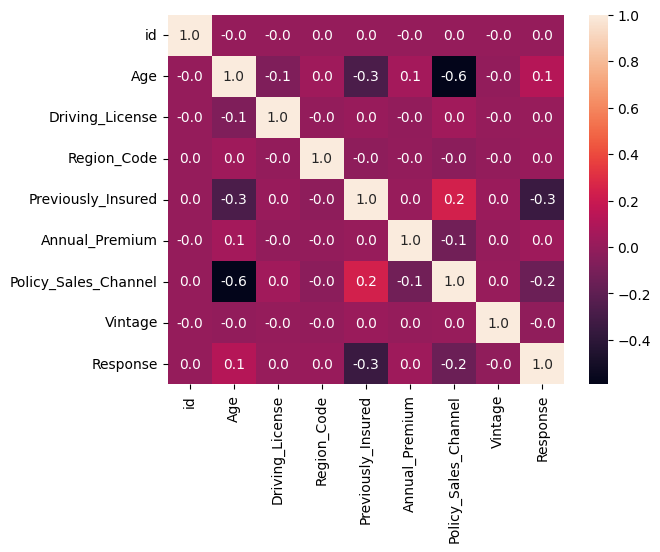

In [17]:
# 상관관계 분석
import seaborn as sns
%matplotlib inline

# 수치형 데이터 간 상관계수 계산
num_corr = df.select_dtypes("number").corr()

# 히트맵 출력
sns.heatmap(num_corr, annot=True, fmt=".1f")

범주형은 어떻게 상관관계를 분석하지?

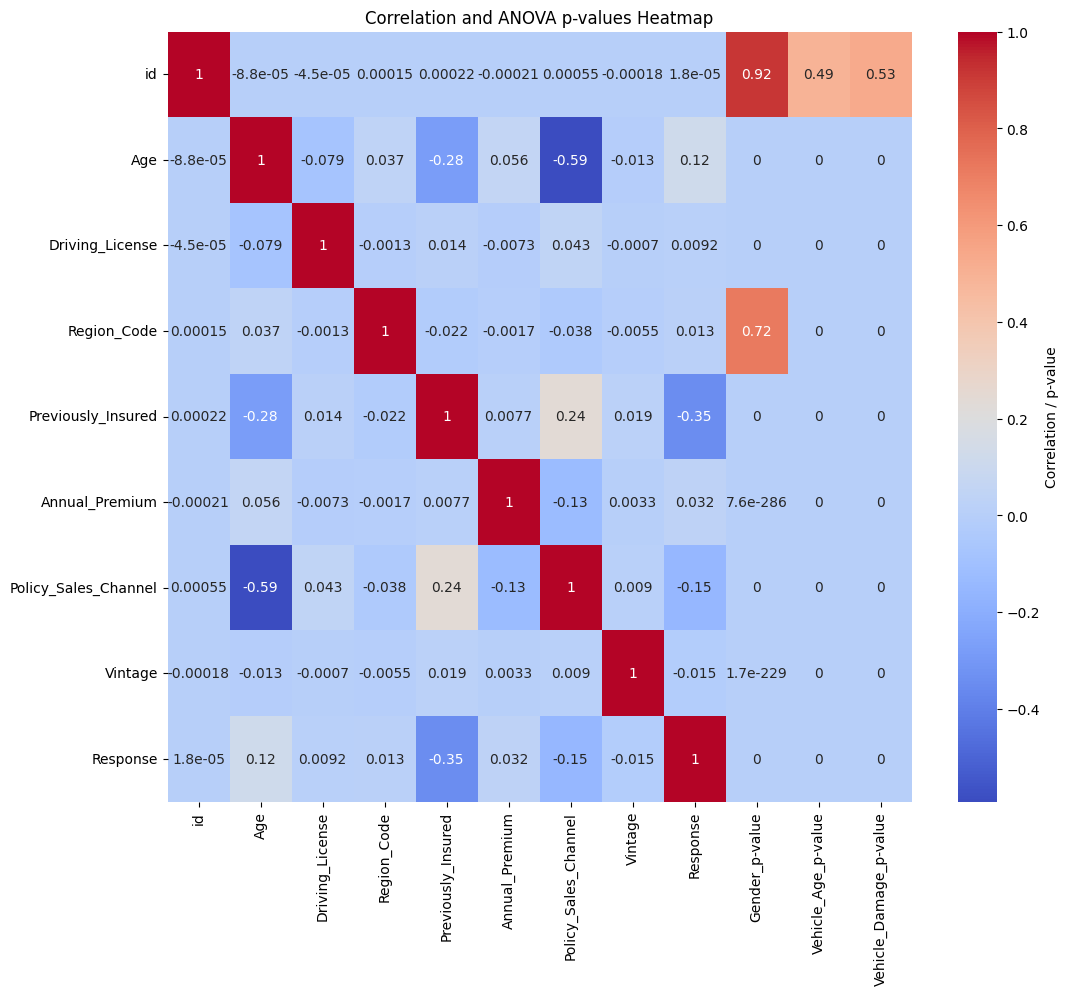

In [19]:
import numpy as np
import scipy.stats as stats

# 범주형 열 선택
cat_cols = df.select_dtypes(include=['category']).columns  # 또는 include=['category'] (범주형 타입으로 되어 있을 경우)

# num_corr = df.select_dtypes(include=[np.number]).corr()

# ANOVA p-values를 저장할 데이터프레임 생성
anova_results = pd.DataFrame(index=df.select_dtypes(include=[np.number]).columns)

# 범주형 열들에 대해 ANOVA 분석 수행
for cat_col in cat_cols:
    for num_col in df.select_dtypes(include=[np.number]).columns:
        groups = [df[df[cat_col] == cat][num_col] for cat in df[cat_col].unique()]
        f_stat, p_val = stats.f_oneway(*groups)
        anova_results.loc[num_col, f'{cat_col}_p-value'] = p_val

# 히트맵용 데이터프레임 생성
heatmap_data = num_corr.copy()
for col in anova_results.columns:
    heatmap_data[col] = anova_results[col].values

# 히트맵 그리기
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation / p-value'})
plt.title('Correlation and ANOVA p-values Heatmap')
plt.show()

#### 2.2 Feature Engineering

### 3. Modelling

In [24]:
# 모델링 전, 모델링에 필요 없는 피처 제거
df.drop(['Cabin'], axis=1, inplace=True)
df.drop(['Name'], axis=1, inplace=True)
df.drop(['PassengerId'], axis=1, inplace=True)

In [25]:
df_train = df

In [26]:
X = df_train.drop("Transported", axis=1).values
y = df_train["Transported"].values  ## 예측하고자 하는 값

In [27]:
# ML을 위한 패키지 가져오기
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

In [28]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6954, 13), (6954,), (1739, 13), (1739,))

#### 3.1 Fit few models
- 선형 회귀(Logistic Regression)
- Random Forest
- Gradient Boosting
- SVM
- MLP

In [29]:
# Logistic Regression
lg = LogisticRegression()
lg.fit(X_train, y_train)
lg_pred_score = lg.score(X_test, y_test)

/Users/key-tech/Developer/_Prj./24.06-AIFEL-Research/Kaggle - Spaceship Titanic/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


위에서 `ValueError: could not convert string to float: 'G/734/S'` 에러가 발생했는데, 'Cabin' 컬럼을 지우지 않아서 생긴 문제인 것 같다.
-> 엉! 맞다~ 그 'Cabin' 외에도 'Name', 'PassengerId' 컬럼 또한 제거해야 한다.

In [30]:
# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred_score = rf.score(X_test, y_test)

In [31]:
# Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
gb_pred_score = gb.score(X_test, y_test)


In [32]:
# Support Vector Machine Classifier
svm = SVC()
svm.fit(X_train, y_train)
svm_pred_score = svm.score(X_test, y_test)

In [33]:
# ANN을 적용하기 위한 패키지 가져오기
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

In [34]:
# 하이퍼파라미터 선택지 설정
parameter_space = {
    'hidden_layer_sizes': [(5,2), (15,), (50,30), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [1e-5, 1e-4, 0.001, 0.05],
    'learning_rate': ['constant', 'adaptive']
}

mlp = MLPClassifier(max_iter=100)

# GridSearchCV를 통해 가장 좋은 성능을 내주는 하이퍼파라미터 조합 찾기
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)
print(f"Best parameters found: {clf.best_params_}")

best_model = clf.best_estimator_
test_score = best_model.score(X_test, y_test)
print(f"Test accuracy: {test_score}")

/Users/key-tech/Developer/_Prj./24.06-AIFEL-Research/Kaggle - Spaceship Titanic/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/key-tech/Developer/_Prj./24.06-AIFEL-Research/Kaggle - Spaceship Titanic/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/key-tech/Developer/_Prj./

Best parameters found: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
Test accuracy: 0.7711328349626222


In [35]:
# Multi Layer Perceptron
# (위에서 나온 최적 하이퍼파라미터 조합 적용)
mlp = MLPClassifier(
                hidden_layer_sizes=(100,),
                activation='tanh',
                solver='adam',
                alpha=1e-5,
                learning_rate='constant'
            )
mlp.fit(X_train, y_train)
mlp_pred_score = mlp.score(X_test, y_test)

In [36]:
# 테스트 결과 데이터프레임화
df = pd.DataFrame(dict(model=[
                            'Logistic Regression', 
                            'Random Forest', 
                            'Gradient Boosting',
                            'SVM',
                            'MLP'
                        ],
                       accuracy=[
                           lg_pred_score,
                           rf_pred_score,
                           gb_pred_score,
                           svm_pred_score,
                           mlp_pred_score
                        ]))
df

,model,accuracy
0,Logistic Regression,0.769408
1,Random Forest,0.790109
2,Gradient Boosting,0.797585
3,SVM,0.769408
4,MLP,0.765382


(0.75, 0.8)

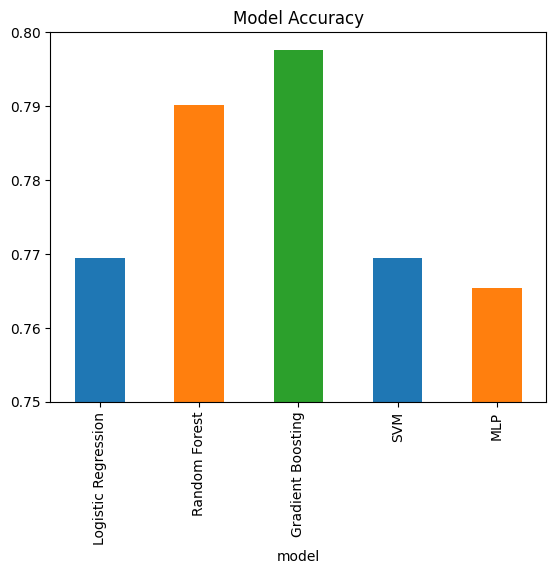

In [37]:
# 테스트 결과 시각화
df.plot(kind='bar',x='model',y='accuracy',title='Model Accuracy',legend=False,
        color=['#1F77B4', '#FF7F0E', '#2CA02C'])
plt.ylim(0.75,0.8)

#### Ex. Retrospect

**회고록**

잘 된 점:


어려웠던 점: 

궁금한 점: 

**참고 자료**
- 
